In [1]:
# regional_development_simulation_improved.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist


def gini_coefficient(x):
    x = np.array(x)
    if np.any(x < 0):
        raise ValueError("Gini coefficient is defined for non-negative values only.")
    n = len(x)
    if n == 0:
        return 0.0
    sorted_x = np.sort(x)
    cumsum_x = np.cumsum(sorted_x)
    sum_x = cumsum_x[-1]
    if sum_x == 0:
        return 0.0
    index = np.arange(1, n + 1)
    gini = (2 * np.sum(index * sorted_x)) / (n * sum_x) - (n + 1) / n
    return gini


In [2]:
def run_simulation(policy_mode="carbon_tax", seed=2025):
    np.random.seed(seed)
    
    # ----------------------------
    # 配置参数
    # ----------------------------
    n_regions = 10
    d = 6
    T_max = 100
    shock_period = 12
    env_gamma = 0.5
    phi_base = 0.2

    alpha = np.array([0.2, 0.2, 0.15, 0.15, 0.15, 0.15])

    geo_pos = np.random.rand(n_regions, 2)
    D_geo = cdist(geo_pos, geo_pos, metric='euclidean')
    D_geo_norm = D_geo / (D_geo.max() + 1e-8)

    # 初始状态
    X = np.exp(np.random.normal(0, 0.5, (n_regions, d)))
    Theta = np.exp(np.random.normal(0, 0.4, (n_regions, d)))
    savings = np.random.beta(2, 5, n_regions) * 0.4 + 0.1
    y_history = [np.zeros(n_regions) for _ in range(3)]

    total_output = []
    env_levels = []
    gini_list = []
    cluster_counts = []
    final_y = None
    labels = np.zeros(n_regions, dtype=int)
    E = 100.0

    # 新增：环境容量与污染系数
    max_capacity = 200.0
    pollution_intensity = 0.05     # 每单位产出产生 0.05 单位污染,
    abatement_efficiency = 0.65     # 碳税修复效率，0.85太高，改为0.45

    # 修改：增加基础修复比例，确保环境不会持续恶化
    base_repair_fraction = 0.03  # 
    # 新增：绿色技术对污染的缓解因子
    green_tech_reduction = 0.40

    # 新增：绿色补贴条件调整
    # required_emission_reduction = 0.005  # 降低到0.5%，更容易触发
    
    # 新增：记录补贴激活状态的列表
    subsidy_active_history = []
    # 新增：记录综合得分的列表
    composite_score_history = []
    
    # 新增：保存上一期的环境资本，用于计算减排率
    prev_E = E

    # 新增：绿色补贴相关的状态变量
    subsidy_activation_count = 0  # 连续激活期数
    subsidy_inactive_count = 0    # 连续未激活期数
    cumulative_green_score = 0.0  # 累积绿色得分
    subsidy_base_rate = 0.05      # 基础补贴率
    min_activation_periods = 5    # 最小连续激活期数

    for t in range(T_max):
        # 1. 产出
        X_eff = np.clip(X * Theta, 1e-6, 10.0)
        log_y = np.sum(alpha * np.log(X_eff), axis=1)
        y_raw = np.exp(log_y)
        env_factor = min(1.0, (max(E, 1e-6) / 100.0) ** env_gamma)
        y_env = y_raw * env_factor

        # 2. 冲击
        if t % shock_period == 0 and t > 0:
            shock = np.random.uniform(0.4, 1.6)
            y = y_env * shock
        else:
            y = y_env

        # 3. 距离与合作
        y_history.pop(0)
        y_history.append(y.copy())
        Y_hist = np.array(y_history).T
        D_inst = cdist(Y_hist, Y_hist, metric='euclidean')
        D_inst = D_inst / (D_inst.max() + 1e-8)
        trade_cost = 0.6 * D_geo_norm + 0.4 * D_inst

        # 动态聚类
        best_n_clusters = 2
        max_sil = -2
        valid_found = False
        for n_cl in range(2, min(7, n_regions)):
            try:
                clust_model = AgglomerativeClustering(
                    n_clusters=n_cl,
                    metric='precomputed',
                    linkage='average'
                )
                pred_labels = clust_model.fit_predict(trade_cost)
                if len(np.unique(pred_labels)) < 2:
                    continue
                sil = silhouette_score(trade_cost, pred_labels, metric='precomputed')
                if sil > max_sil:
                    max_sil = sil
                    best_n_clusters = n_cl
                    valid_found = True
            except Exception:
                continue

        if valid_found:
            clustering = AgglomerativeClustering(
                n_clusters=best_n_clusters,
                metric='precomputed',
                linkage='average'
            )
            labels = clustering.fit_predict(trade_cost)
        else:
            labels = np.zeros(n_regions, dtype=int)

        # 4. 合作投资
        X_next = X.copy()
        for cid in np.unique(labels):
            mask = (labels == cid)
            if not np.any(mask):
                continue
            cluster_y = y[mask]
            total_y = cluster_y.sum()
            if total_y <= 1e-8:
                continue
            coop_gain = 0.1
            total_with_gain = total_y * (1 + coop_gain)
            avg_saving = np.mean(savings[mask])
            investment = total_with_gain * avg_saving
            current_level = X[mask].mean(axis=0) + 1.0
            delta_X = (investment * 0.2 / d) / current_level
            X_next[mask] += delta_X
        X_next = np.clip(X_next, 1e-6, 10.0)

        # 5. 技术更新
        if t % 10 == 0:
            new_Theta = Theta.copy()
            for i in range(n_regions):
                same_cluster = (labels == labels[i])
                geo_weights = np.exp(-2.0 * D_geo[i])
                weights = geo_weights * same_cluster
                weights[i] = 0
                total_weight = weights.sum()
                if total_weight > 1e-6:
                    avg_theta = np.dot(weights, Theta) / total_weight
                    tech_level = Theta[i].mean()
                    learning_capacity = 1.0 / (1.0 + np.exp(-(tech_level - 1.0)))
                    lr = 0.05
                    new_Theta[i] += lr * learning_capacity * (avg_theta - Theta[i])
                if np.random.rand() < 0.02:
                    noise = np.random.normal(0, 0.08, d)
                    new_Theta[i] += noise
            Theta = np.clip(new_Theta, 0.1, 3.0)

        # ==============================
        # 6. 政策与环境资本更新（修复版）
        # ==============================
        
        # 计算总污染排放（考虑绿色技术减污效果）
        green_tech_avg = Theta[:, -1].mean()
        effective_pollution_intensity = pollution_intensity * (1 - min(green_tech_avg * green_tech_reduction, 0.8))
        total_pollution = effective_pollution_intensity * y.sum()
        
        # 环境压力
        environmental_pressure = min(total_pollution, max_capacity)
        
        # 绿色补贴的激活状态（初始化为0）
        subsidy_active = 0
        # subsidy_amount = 0
        
        # 所有政策下都有基础修复资金
        base_green_repair = base_repair_fraction * y.sum()

        # 【修复关键点】重新设计绿色补贴逻辑
        if policy_mode == "green_subsidy":
            green_tech = Theta[:, -1]
            # 【关键修改1】: 确保补贴与污染成比例
            # 计算理论上的最优修复资金：至少能抵消污染的50%
            optimal_repair = environmental_pressure * 0.7  # 目标是修复70%的污染
            
            # 【关键修改2】: 动态调整补贴池大小
            # 补贴池 = 基础补贴 + 与污染成比例的额外补贴
            subsidy_base = 0.05 * y.sum()
            pollution_based_addition = 0.02 * environmental_pressure
            subsidy_pool = subsidy_base + pollution_based_addition
            
            # 【关键修改3】: 确保至少有一部分资金用于环境修复
            # 无论激活条件如何，都至少使用一部分资金进行环境修复
            
            guaranteed_repair = max(base_green_repair, optimal_repair * 0.3)

            # 【优化1】: 动态调整绿色技术阈值
            # 使用滑动窗口的平均值，避免短期波动
            if t < 20:
                # 早期使用较低阈值鼓励发展
                green_tech_threshold = np.percentile(green_tech, 50)  # 前50%
            else:
                # 后期逐渐提高标准
                green_tech_threshold = np.percentile(green_tech, 60)  # 前40%为绿色技术领先者
            
            # 识别绿色技术区域
            subsidy_eligible = green_tech > green_tech_threshold
            
            # 【新的触发条件】多维度综合判断；更加平滑的评分系统
            # 条件1：绿色技术平均水平是否在提升
            green_tech_growth = 0
            if t > 0 and 'prev_green_tech_avg' in locals():
                green_tech_growth = (green_tech_avg - prev_green_tech_avg) / max(prev_green_tech_avg, 1e-6)
            
            # 条件2：污染强度是否在下降
            pollution_reduction = 0
            if t > 0 and 'prev_pollution_intensity' in locals():
                pollution_reduction = (prev_pollution_intensity - effective_pollution_intensity) / max(prev_pollution_intensity, 1e-6)
            
            # 条件3：环境资本是否有改善
            env_improvement = 0
            if t > 0:
                env_improvement = (E - prev_E) / max(prev_E, 1e-6)
            
            # 【优化3】: 连续权重调整（考虑历史表现）
            # 基础权重
            weights = [0.4, 0.3, 0.3]
            
            # 如果连续多期未激活，降低门槛
            if subsidy_inactive_count > 10:
                weights = [0.3, 0.4, 0.3]  # 更看重污染减少
            
            # 【优化4】: 平滑评分（0-1连续值，而非二元判断）
            green_score = max(0, min(1, green_tech_growth / 0.01))  # 1%增长得满分
            pollution_score = max(0, min(1, pollution_reduction / 0.005))  # 0.5%减少得满分
            env_score = max(0, min(1, (env_improvement + 0.01) / 0.02))  # 改善1%得满分

            # 综合得分：满足任一条件即可激活补贴(连续值)
            # 权重可以调整
            composite_score = (
                weights[0] * green_score +  # 绿色技术有增长
                weights[1] * pollution_score +  # 污染强度下降
                weights[2] * env_score      # 环境资本没有大幅恶化
            )

            # 【优化5】: 累积得分和历史考虑
            # 使用指数加权移动平均平滑得分
            alpha_smooth = 0.2  # 平滑系数
            if t == 0:
                cumulative_green_score = composite_score
            else:
                cumulative_green_score = (alpha_smooth * composite_score + 
                                        (1 - alpha_smooth) * cumulative_green_score)
            
            # 【优化6】: 动态阈值，考虑历史表现和政策连续性
            if t < 30:
                # 早期：较低门槛鼓励发展
                threshold = 0.14
            elif subsidy_activation_count > 0:
                # 已激活期：维持较低门槛，避免政策中断
                threshold = max(0.2, 0.5 - subsidy_activation_count * 0.02)
            else:
                # 未激活期：正常门槛
                threshold = 0.5
            
            # 【优化7】: 特殊触发机制
            # 如果连续多期未激活，强制触发一段时间
            if subsidy_inactive_count > 15 and t > 30:
                # 连续15期未激活后，强制激活至少5期
                if subsidy_inactive_count <= 20:
                    subsidy_active = 1
                    print(f"期数 {t}: 强制激活绿色补贴（连续{subsidy_inactive_count}期未激活）")
                else:
                    # 超过20期后恢复正常逻辑
                    pass


            # 正常激活条件
            if composite_score >= threshold or cumulative_green_score >= 0.4:
                subsidy_active = 1
            
            # 【优化8】: 渐进式补贴金额
            if subsidy_active:
                subsidy_activation_count += 1
                subsidy_inactive_count = 0
                
                # 补贴金额与得分成正比
                subsidy_multiplier = min(1.5, 0.5 + composite_score * 1.5)
                subsidy_base = subsidy_base_rate * y.sum()
                subsidy_pool = subsidy_base * subsidy_multiplier
                
                if subsidy_eligible.any():
                    # 1. 分配补贴给绿色技术区域
                    subsidy_per_region = subsidy_pool * 0.3 / subsidy_eligible.sum()  # 30%用于直接补贴
                    y[subsidy_eligible] += subsidy_per_region
                    
                    # 一部分用于技术升级
                    tech_upgrade_fraction = 0.3
                    tech_upgrade = tech_upgrade_fraction * subsidy_pool
                    upgrade_per_region = tech_upgrade / subsidy_eligible.sum() * 0.05
                    for i in range(n_regions):
                        if subsidy_eligible[i]:
                            Theta[i][-1] += upgrade_per_region
                    
                    # 剩余用于环境修复
                    green_repair = (1 - tech_upgrade_fraction - 0.3) * subsidy_pool
                else:
                    green_repair = 0.0
                    # subsidy_amount = 0
            else:
                subsidy_inactive_count += 1
                subsidy_activation_count = 0
                green_repair = 0.0
                # subsidy_amount = 0
            # 记录综合得分
            subsidy_active_history.append(subsidy_active)
            composite_score_history.append(composite_score)

            # 总修复资金 = 基础修复 + 补贴修复 + 保证的最小修复
            total_green_repair = base_green_repair + green_repair + guaranteed_repair

            # 保存当前值用于下一期计算
            prev_green_tech_avg = green_tech_avg
            prev_pollution_intensity = effective_pollution_intensity
            
        elif policy_mode == "carbon_tax":
            tax_rate = 0.08
            carbon_tax = tax_rate * y
            y_after_tax = y - carbon_tax
            env_revenue = carbon_tax.sum()
            green_repair = env_revenue * abatement_efficiency
            
            # 再分配：55% 税收用于底部 30%
            redistribution_fraction = 1 - abatement_efficiency #设为0.8
            redistribution_amount = env_revenue * redistribution_fraction
            sorted_idx = np.argsort(y_after_tax)
            k30 = max(1, int(0.3 * n_regions))
            bot30 = sorted_idx[:k30]
            y_after_tax[bot30] += redistribution_amount / len(bot30)
            y = y_after_tax

            # 总修复资金 = 基础修复 + 碳税修复
            total_green_repair = base_green_repair + green_repair
            subsidy_active = 0  # 碳税政策下不记录补贴激活
            # 碳税政策下，综合得分设为0（或可以用其他指标）            
            composite_score_history.append(0.0)

        else:
            total_green_repair = base_green_repair
            subsidy_active = 0


        # 如果修复资金不足，增加额外修复
        if total_green_repair < environmental_pressure * 0.5:
            # 如果修复资金不足污染的50%，增加额外修复
            additional_repair = environmental_pressure * 0.5 - total_green_repair
            total_green_repair += additional_repair * 0.5  # 增加部分修复

        # 【核心修复】环境资本更新
        E = max(1.0, E - environmental_pressure + total_green_repair)
        E = min(E, max_capacity)
        
        # 保存当前环境资本用于下一期计算
        prev_E = E

        if policy_mode == "green_subsidy" and t % 20 == 0:
            print(f"期数 {t}: 绿色技术增长={green_tech_growth:.4f}, "
                f"污染减少={pollution_reduction:.4f}, "
                f"环境改善={env_improvement:.4f}, "
                f"综合得分={composite_score:.3f}, "
                f"阈值={threshold:.3f}, "
                f"激活={subsidy_active}")
            
        # 7. 更新储蓄
        y_avg = y.mean() + 1e-8
        savings = np.clip(savings + 0.05 * (y / y_avg - 1), 0.05, 0.6)

        # 8. 记录
        total_output.append(y.sum())
        env_levels.append(E)
        gini_list.append(gini_coefficient(y))
        cluster_counts.append(len(np.unique(labels)))
        if t == T_max - 1:
            final_y = y.copy()

        X = X_next

    return {
        'total_output': total_output,
        'env_levels': env_levels,
        'gini_list': gini_list,
        'cluster_counts': cluster_counts,
        'final_y': final_y,
        'geo_pos': geo_pos,
        'policy': policy_mode,
        'subsidy_active': subsidy_active_history if policy_mode == "green_subsidy" else [],
        'composite_score_history': composite_score_history 
    }

期数 0: 绿色技术增长=0.0000, 污染减少=0.0000, 环境改善=0.0000, 综合得分=0.150, 阈值=0.140, 激活=1
期数 20: 绿色技术增长=0.0012, 污染减少=0.0012, 环境改善=0.0000, 综合得分=0.271, 阈值=0.140, 激活=1
期数 40: 绿色技术增长=0.0013, 污染减少=0.0013, 环境改善=0.0000, 综合得分=0.280, 阈值=0.200, 激活=1
期数 60: 绿色技术增长=0.0053, 污染减少=0.0056, 环境改善=0.0000, 综合得分=0.662, 阈值=0.500, 激活=1
期数 78: 强制激活绿色补贴（连续16期未激活）
期数 80: 绿色技术增长=0.0000, 污染减少=0.0000, 环境改善=0.0000, 综合得分=0.155, 阈值=0.500, 激活=0
期数 95: 强制激活绿色补贴（连续16期未激活）
绿色补贴激活统计:
  总期数: 100
  激活期数: 54
  激活率: 54.00%
  最长连续激活: 50期

=== Policy Comparison (Improved Model) ===
Carbon Tax     - Final Gini: 0.352, Env: 193.91
Green Subsidy  - Final Gini: 0.337, Env: 200.00


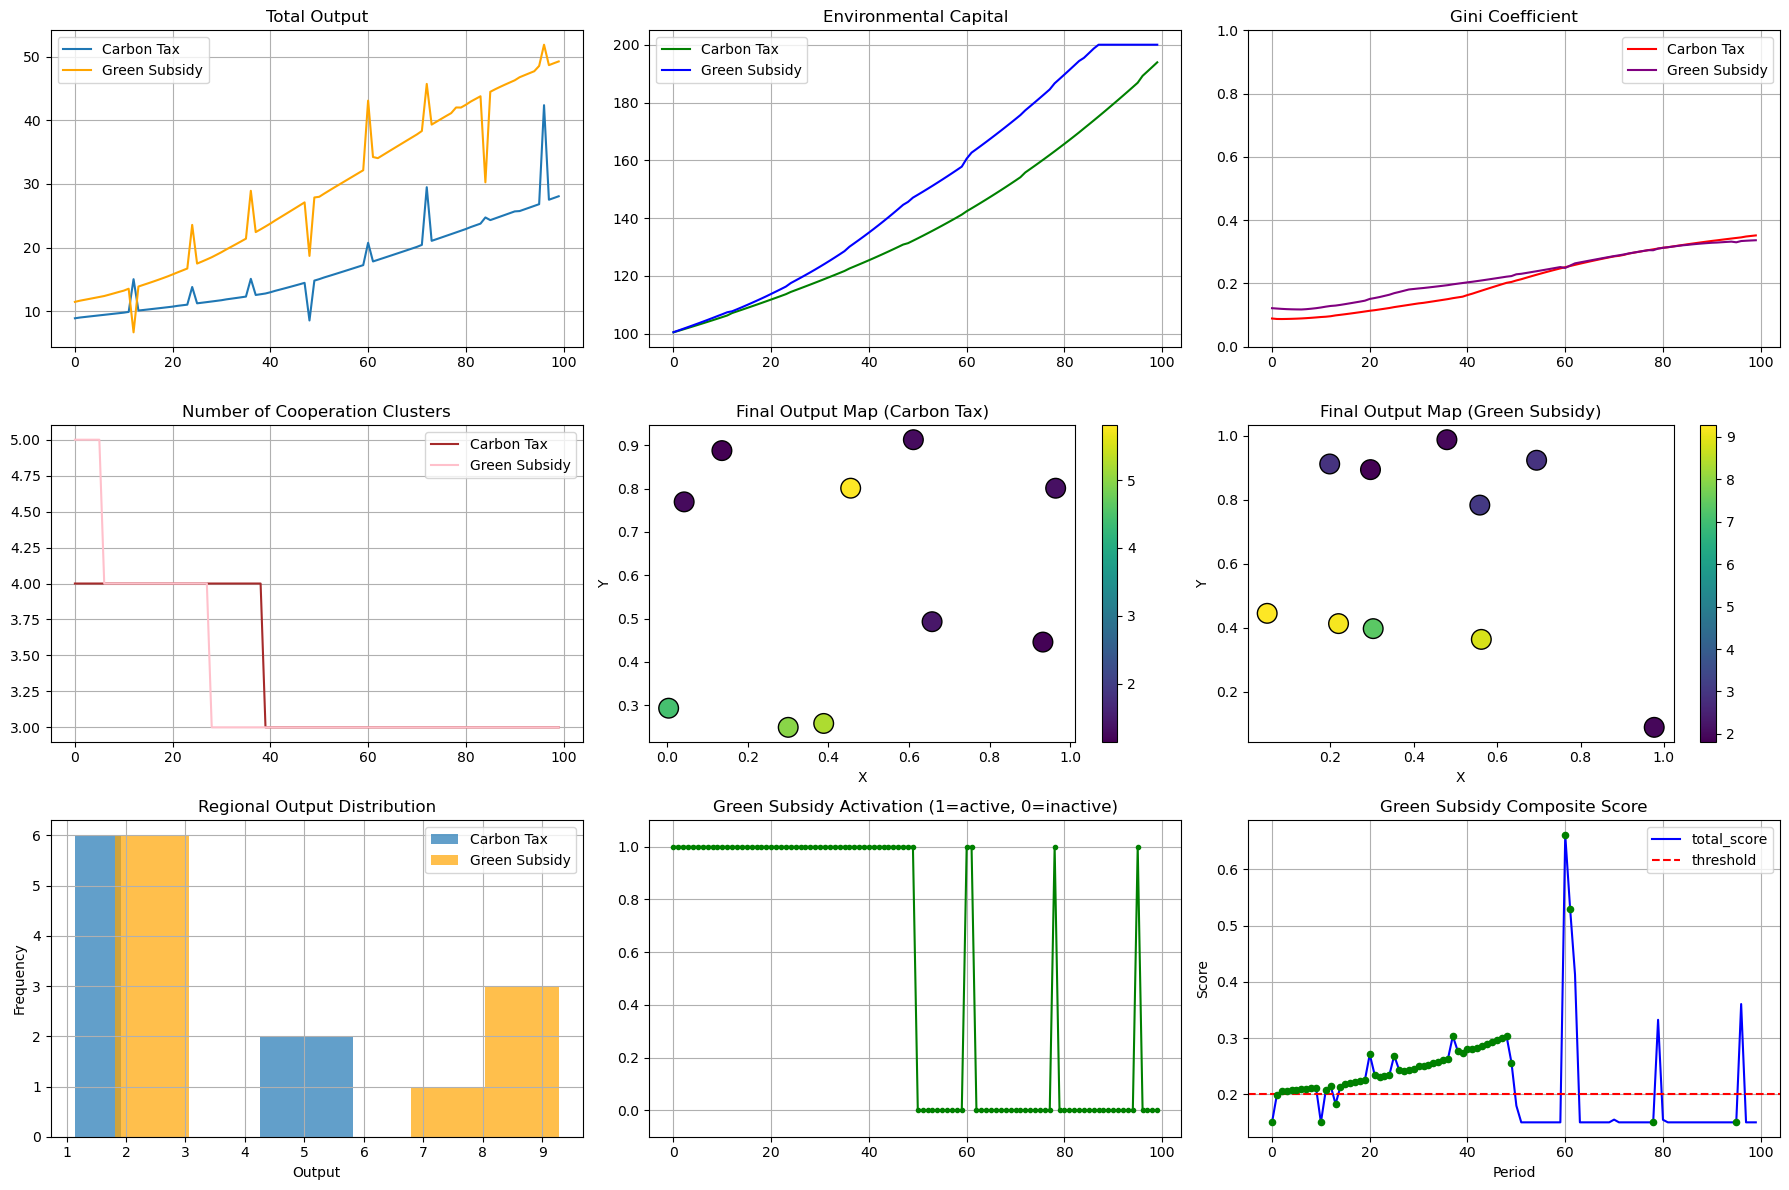

In [3]:
    
def main():
    # 运行两种政策（使用不同种子）
    results_carbon = run_simulation(policy_mode="carbon_tax", seed=2025)
    results_subsidy = run_simulation(policy_mode="green_subsidy", seed=2026)

    # 分析补贴激活模式
    subsidy_active = results_subsidy.get('subsidy_active', [])
    if subsidy_active:
        active_periods = sum(subsidy_active)
        total_periods = len(subsidy_active)
        activation_rate = active_periods / total_periods
        
        print(f"绿色补贴激活统计:")
        print(f"  总期数: {total_periods}")
        print(f"  激活期数: {active_periods}")
        print(f"  激活率: {activation_rate:.2%}")
        
        # 计算最长连续激活期数
        max_consecutive = 0
        current = 0
        for s in subsidy_active:
            if s:
                current += 1
                max_consecutive = max(max_consecutive, current)
            else:
                current = 0
        print(f"  最长连续激活: {max_consecutive}期")

    # ----------------------------
    # 绘制对比图
    # ----------------------------
    fig = plt.figure(figsize=(18, 12))

    # 总产出对比
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(results_carbon['total_output'], label='Carbon Tax', color='tab:blue')
    plt.plot(results_subsidy['total_output'], label='Green Subsidy', color='orange')
    plt.title('Total Output')
    plt.legend()
    plt.grid(True)

    # 环境资本对比
    ax2 = plt.subplot(3, 3, 2)
    plt.plot(results_carbon['env_levels'], label='Carbon Tax', color='green')
    plt.plot(results_subsidy['env_levels'], label='Green Subsidy', color='blue')
    plt.title('Environmental Capital')
    plt.legend()
    plt.grid(True)

    # 基尼系数对比
    ax3 = plt.subplot(3, 3, 3)
    plt.plot(results_carbon['gini_list'], label='Carbon Tax', color='red')
    plt.plot(results_subsidy['gini_list'], label='Green Subsidy', color='purple')
    plt.title('Gini Coefficient')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)

    # 合作簇数对比
    ax4 = plt.subplot(3, 3, 4)
    plt.plot(results_carbon['cluster_counts'], label='Carbon Tax', color='brown')
    plt.plot(results_subsidy['cluster_counts'], label='Green Subsidy', color='pink')
    plt.title('Number of Cooperation Clusters')
    plt.legend()
    plt.grid(True)

    # 热力图：碳税
    ax5 = plt.subplot(3, 3, 5)
    sc1 = plt.scatter(
        results_carbon['geo_pos'][:, 0],
        results_carbon['geo_pos'][:, 1],
        c=results_carbon['final_y'],
        s=200,
        cmap='viridis',
        edgecolor='k'
    )
    plt.colorbar(sc1, ax=ax5)
    plt.title('Final Output Map (Carbon Tax)')
    plt.xlabel('X')
    plt.ylabel('Y')

    # 热力图：补贴
    ax6 = plt.subplot(3, 3, 6)
    sc2 = plt.scatter(
        results_subsidy['geo_pos'][:, 0],
        results_subsidy['geo_pos'][:, 1],
        c=results_subsidy['final_y'],
        s=200,
        cmap='viridis',
        edgecolor='k'
    )
    plt.colorbar(sc2, ax=ax6)
    plt.title('Final Output Map (Green Subsidy)')
    plt.xlabel('X')
    plt.ylabel('Y')

    # 区域产出分布直方图
    ax7 = plt.subplot(3, 3, 7)
    plt.hist(results_carbon['final_y'], bins=6, alpha=0.7, label='Carbon Tax', color='tab:blue')
    plt.hist(results_subsidy['final_y'], bins=6, alpha=0.7, label='Green Subsidy', color='orange')
    plt.title('Regional Output Distribution')
    plt.xlabel('Output')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    # 子图8：绿色补贴激活状态
    if 'subsidy_active' in results_subsidy:
        ax8 = plt.subplot(3, 3, 8)
        plt.plot(results_subsidy['subsidy_active'], color='green', marker='o', markersize=3)
        plt.title('Green Subsidy Activation (1=active, 0=inactive)')
        plt.ylim(-0.1, 1.1)
        plt.grid(True)

    # 子图9：绿色补贴综合得分变化
    ax9 = plt.subplot(3, 3, 9)
    if 'composite_score_history' in results_subsidy:
        plt.plot(results_subsidy['composite_score_history'], label='total_score', color='blue')
        # 添加阈值线
        plt.axhline(y=0.2, color='red', linestyle='--', label='threshold')
        # 标记激活区域
        for i, score in enumerate(results_subsidy['composite_score_history']):
            if i < len(results_subsidy.get('subsidy_active', [])) and results_subsidy['subsidy_active'][i]:
                plt.scatter(i, score, color='green', s=20, zorder=5)
        plt.title('Green Subsidy Composite Score')
        plt.xlabel('Period')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'No composite score data', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax9.transAxes)
        plt.title('Composite Score (Not Available)')
    

        
    # 打印最终指标
    print("\n=== Policy Comparison (Improved Model) ===")
    print(f"Carbon Tax     - Final Gini: {results_carbon['gini_list'][-1]:.3f}, Env: {results_carbon['env_levels'][-1]:.2f}")
    print(f"Green Subsidy  - Final Gini: {results_subsidy['gini_list'][-1]:.3f}, Env: {results_subsidy['env_levels'][-1]:.2f}")

    plt.tight_layout()
    plt.savefig('policy_comparison_results_improved.png', dpi=150)
    plt.show()


if __name__ == "__main__":
    main()